## Initialization

### Libraries

In [22]:
import numpy as np
from pandas import read_csv
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import os

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.mixture import GaussianMixture
from sklearn.mixture import BayesianGaussianMixture

from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import normalize

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix as pcm
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix

from keras.layers import Input, Dense
from keras.models import Model, Sequential
from keras import regularizers
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.optimizers import Adam

import librosa
from librosa.feature import mfcc as mfcc
import librosa.display
import IPython.display as ipd


### Mounting Google Drive

In [23]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## Feature Extraction

### LFCC

In [2]:
def lin(sr, n_fft, n_filter=128, fmin=0.0, fmax=None, dtype=np.float32):

    if fmax is None:
        fmax = float(sr) / 2
    # Initialize the weights
    n_filter = int(n_filter)
    weights = np.zeros((n_filter, int(1 + n_fft // 2)), dtype=dtype)

    # Center freqs of each FFT bin
    fftfreqs = librosa.fft_frequencies(sr=sr, n_fft=n_fft)

    # 'Center freqs' of liner bands - uniformly spaced between limits
    linear_f = np.linspace(fmin, fmax, n_filter + 2)

    fdiff = np.diff(linear_f)
    ramps = np.subtract.outer(linear_f, fftfreqs)

    for i in range(n_filter):
        # lower and upper slopes for all bins
        lower = -ramps[i] / fdiff[i]
        upper = ramps[i + 2] / fdiff[i + 1]

        # .. then intersect them with each other and zero
        weights[i] = np.maximum(0, np.minimum(lower, upper))

    return weights


def linear_spec(y=None,
                sr=22050,
                n_fft=2048,
                hop_length=512,
                win_length=None,
                window='hann',
                center=True,
                pad_mode='reflect',
                power=2.0,
                **kwargs):
    S = np.abs(
        librosa.core.stft(y=y,
                          n_fft=n_fft,
                          hop_length=hop_length,
                          win_length=win_length,
                          window=window,
                          center=center,
                          pad_mode=pad_mode))**power
    filter = lin(sr=sr, n_fft=n_fft, **kwargs)
    return np.dot(filter, S)


def lfcc(y=None,
         sr=22050,
         S=None,
         n_lfcc=20,
         dct_type=2,
         norm='ortho',
         **kwargs):
    if S is None:
        S = librosa.power_to_db(linear_spec(y=y, sr=sr, **kwargs))
    M = scipy.fftpack.dct(S, axis=0, type=dct_type, norm=norm)[:n_lfcc]
    return M

### Feature extraction

In [4]:
# # assign directory
# directory = '/content/gdrive/MyDrive/Intoxicated'
# lfccsi = []
# # iterate over files in
# # that directory
# for filename in os.listdir(directory):
#   f = os.path.join(directory, filename)
#   # checking if it is a file
#   if os.path.isfile(f):
#     y, sr = librosa.load(f)
#     # lf = lfcc(y, sr, n_lfcc=16)
#     lf = librosa.filters.mel(sr, n_fft= 2048, n_mels = 16)
#     lff = np.mean(lf, axis=1)
#     lff = np.append(lff, 1)
#     lfccsi.append(lff)


In [7]:
# assign directory
directory = '/content/gdrive/MyDrive/Intoxicated'
lfccsi = []
# iterate over files in
# that directory
for filename in os.listdir(directory):
  f = os.path.join(directory, filename)
  # checking if it is a file
  if os.path.isfile(f):
    y, sr = librosa.load(f)
    # zero_crossings = librosa.zero_crossings(y, pad=False)
    # zc = sum(zero_crossings)
    mf = mfcc(y, sr, n_mfcc=16)
    #mf = librosa.filters.mel(sr, n_fft=2048, n_mels = 16)
    delta_mfc = librosa.feature.delta(mf)
    final = np.concatenate((mf, delta_mfc))
    final = normalize(final, axis=1)
    final = np.mean(final, axis=1)
    rmse = librosa.feature.rms(y=y)[0]
    orms = np.mean(rmse)
    fin = np.append(final, orms)
    # fin = np.append(fin, zc)
    fin = np.append(fin, 1)
    lfccsi.append(fin)

In [13]:
# # assign directory
# directory = '/content/gdrive/MyDrive/Sober'
# lfccss = []
# # iterate over files in
# # that directory
# for filename in os.listdir(directory):
#   f = os.path.join(directory, filename)
#   # checking if it is a file
#   if os.path.isfile(f):
#     y, sr = librosa.load(f)
#     #lf = lfcc(y, sr, n_lfcc=16)
#     lf = librosa.filters.mel(sr, n_fft= 2048, n_mels = 16)
#     lff = np.mean(lf, axis=1)
#     lff = np.append(lff, 0)
#     lfccss.append(lff)

In [15]:
# assign directory
directory = '/content/gdrive/MyDrive/Sober'
lfccss = []
# iterate over files in
# that directory
for filename in os.listdir(directory):
  f = os.path.join(directory, filename)
  # checking if it is a file
  if os.path.isfile(f):
    y, sr = librosa.load(f)
    # zero_crossings = librosa.zero_crossings(y, pad=False)
    # zc = sum(zero_crossings)
    mf = mfcc(y, sr, n_mfcc=16)
    #mf = librosa.filters.mel(sr, n_fft=2048, n_mels = 16)
    delta_mfc = librosa.feature.delta(mf)
    final = np.concatenate((mf, delta_mfc))
    final = normalize(final, axis=1)
    final = np.mean(final, axis=1)
    rmse = librosa.feature.rms(y=y)[0]
    orms = np.mean(rmse)
    fin = np.append(final, orms)
    # fin = np.append(fin, zc)
    fin = np.append(fin, 0)
    lfccss.append(fin)

/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


In [17]:
lfccsi = np.array(lfccsi)
lfccss = np.array(lfccss)
print(lfccsi.shape)
print(lfccss.shape)

(840, 34)
(840, 34)


In [18]:
main = np.concatenate((lfccsi, lfccss), axis=0)

In [19]:
main.shape

(1680, 34)

## Neural network (GridSearch)

In [ ]:
X = main[:,0:-1]
y = main[:,-1]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [ ]:
print(X.shape)
print(y.shape)

(1680, 33)
(1680,)


In [ ]:
def create_baseline(learning_rate = 0.01):

  model = Sequential()
  model.add(Dense(33, input_dim=33, activation='relu'))
  model.add(Dense(10, activation='relu'))
  model.add(Dense(1, activation='sigmoid'))

  optimizer = Adam(learning_rate = learning_rate)
  model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
  return model


In [ ]:
#batch_size = [20, 50, 75]
#epochs = [25, 50, 75]
#optimizer = ['SGD', 'Adagrad','Adam', 'Adamax']
learn_rate = [0.001, 0.01, 0.1, 0.2, 0.3]
momentum = [0.0, 0.2, 0.4, 0.6, 0.8, 0.9]
#activation = ['softmax', 'relu', 'tanh', 'sigmoid', 'linear']
#weight_constraint = [1, 3, 5]
#dropout_rate = [0.0, 0.4, 0.8]
#neurons = [5, 10, 20]
#hidden_layers = [1, 2, 3]


In [ ]:
estimator = KerasClassifier(build_fn=create_baseline, epochs=100, batch_size=5, verbose=0)
param_grid = dict(learning_rate = learn_rate)
grid = RandomizedSearchCV(estimator=estimator, param_distributions=param_grid, n_jobs=-1, cv=5, random_state = 42)
grid.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:296: UserWarning: The total space of parameters 5 is smaller than n_iter=10. Running 5 iterations. For exhaustive searches, use GridSearchCV.
  UserWarning,


In [ ]:
print(grid.best_params_)

{'learning_rate': 0.001}


In [ ]:
grid_pred = grid.predict(X_test) 
   
# print classification report
print(classification_report(y_test, grid_pred))

              precision    recall  f1-score   support

         0.0       0.78      0.89      0.83       161
         1.0       0.89      0.77      0.83       175

    accuracy                           0.83       336
   macro avg       0.84      0.83      0.83       336
weighted avg       0.84      0.83      0.83       336



In [ ]:
print('Accuracy : '+str(accuracy_score(y_test, grid_pred)))

Accuracy : 0.8303571428571429


## EER

In [24]:


"""
Python compute equal error rate (eer)
ONLY tested on binary classification

:param label: ground-truth label, should be a 1-d list or np.array, each element represents the ground-truth label of one sample
:param pred: model prediction, should be a 1-d list or np.array, each element represents the model prediction of one sample
:param positive_label: the class that is viewed as positive class when computing EER
:return: equal error rate (EER)
"""
def compute_eer(label, pred, positive_label=1):
    # all fpr, tpr, fnr, fnr, threshold are lists (in the format of np.array)
    fpr, tpr, threshold = roc_curve(label, pred, pos_label = positive_label)
    fnr = 1 - tpr

    # the threshold of fnr == fpr
    eer_threshold = threshold[np.nanargmin(np.absolute((fnr - fpr)))]

    # theoretically eer from fpr and eer from fnr should be identical but they can be slightly differ in reality
    eer_1 = fpr[np.nanargmin(np.absolute((fnr - fpr)))]
    eer_2 = fnr[np.nanargmin(np.absolute((fnr - fpr)))]

    # return the mean of eer from fpr and from fnr
    eer = (eer_1 + eer_2) / 2
    return eer

## Neural network

In [25]:
X = main[:,0:-1]
y = main[:,-1]

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [27]:
# baseline model
def create_baseline(learning_rate = 0.01):
	
  model = Sequential()
  model.add(Dense(33, input_dim=33, activation='relu'))
  model.add(Dense(10, activation='relu'))
  model.add(Dense(1, activation='sigmoid'))
	
  optimizer = Adam(learning_rate = learning_rate)
  model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
  return model

In [28]:
estimator = KerasClassifier(build_fn=create_baseline, epochs=100, batch_size=5, verbose=0)
kfold = StratifiedKFold(n_splits=5, shuffle=True)
results = cross_val_score(estimator, X, y, cv=kfold)
print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  """Entry point for launching an IPython kernel.


Baseline: 82.56% (1.40%)


In [29]:
estimator.fit(X_train, y_train)
y_pred = estimator.predict(X_test)
eer = compute_eer(y_test, y_pred, positive_label = 1)
print("EER: ", eer)

EER:  0.16666666666666663


In [30]:
eer = compute_eer(y_test, y_pred, positive_label = 1)
print("EER: ", eer)

EER:  0.16666666666666663


In [31]:
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[130  26]
 [ 30 150]]


In [32]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.81      0.83      0.82       156
         1.0       0.85      0.83      0.84       180

    accuracy                           0.83       336
   macro avg       0.83      0.83      0.83       336
weighted avg       0.83      0.83      0.83       336



## SVM

In [65]:
X = main[:,0:-1]
y = main[:,-1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [66]:
estimator = SVC()
kfold = StratifiedKFold(n_splits=5, shuffle=True)
results = cross_val_score(estimator, X, y, cv=kfold)
print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Baseline: 80.89% (1.14%)


In [67]:
# Building the Support Vector Machine and evaluating it’s performance

# Building the SVM model
svmclf = SVC()
svmclf.fit(X_train, y_train)
  
# Storing the predictions of the non-linear model
y_pred_svmclf = svmclf.predict(X_test)
  
# Evaluating the performance of the non-linear model
print('Accuracy : '+str(accuracy_score(y_test, y_pred_svmclf)))

Accuracy : 0.7767857142857143


EER:  0.22190503209333662


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


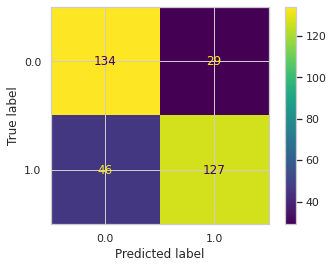

In [68]:
estimator.fit(X_train, y_train)
y_pred = estimator.predict(X_test)
eer = compute_eer(y_test, y_pred, positive_label = 1)
print("EER: ", eer)
cm = pcm(estimator, X_test, y_test)
print(cm)

In [69]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.74      0.82      0.78       163
         1.0       0.81      0.73      0.77       173

    accuracy                           0.78       336
   macro avg       0.78      0.78      0.78       336
weighted avg       0.78      0.78      0.78       336



## Random Forest (GridSearchCV)

In [ ]:
X = main[:,0:-1]
y = main[:,-1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [ ]:
n_estimators = [50, 100, 250, 500]      # Number of trees in random forest
max_features = ['auto', 'sqrt']         # Number of features to consider at every split
max_depth = [2, 5, 7, 10]               # Maximum number of levels in tree
min_samples_split = [2, 5, 10]          # Minimum number of samples required to split a node
min_samples_leaf = [1, 2, 4]            # Minimum number of samples required at each leaf node
bootstrap = [True, False]               # Method of selecting samples for training each tree

In [ ]:
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [ ]:
rf = RandomForestClassifier() 

In [ ]:
grid = RandomizedSearchCV(estimator=rf, param_distributions=random_grid, n_jobs=-1, cv=5, random_state = 42)
grid.fit(X_train, y_train)
print(grid.best_params_)

{'n_estimators': 500, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 10, 'bootstrap': True}


In [ ]:
grid.fit(X_train, y_train)
grid_pred = grid.predict(X_test) 
   
print(classification_report(y_test, grid_pred))
print('Accuracy : '+str(accuracy_score(y_test, grid_pred)))

              precision    recall  f1-score   support

         0.0       0.77      0.81      0.79       175
         1.0       0.78      0.73      0.76       161

    accuracy                           0.77       336
   macro avg       0.77      0.77      0.77       336
weighted avg       0.77      0.77      0.77       336

Accuracy : 0.7738095238095238


## Random Forest

In [71]:
X = main[:,0:-1]
y = main[:,-1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [72]:
estimator = RandomForestClassifier(n_estimators = 500, min_samples_split = 5, min_samples_leaf = 1, max_features = 'sqrt', max_depth = 10, bootstrap = True)
kfold = StratifiedKFold(n_splits=5, shuffle=True)
results = cross_val_score(estimator, X, y, cv=kfold)
print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Baseline: 80.71% (2.40%)


EER:  0.18974404868444603


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


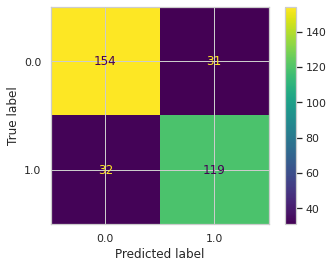

In [73]:
estimator.fit(X_train, y_train)
y_pred = estimator.predict(X_test)
eer = compute_eer(y_test, y_pred, positive_label = 1)
print("EER: ", eer)
cm = pcm(estimator, X_test, y_test)
print(cm)

In [74]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.83      0.83      0.83       185
         1.0       0.79      0.79      0.79       151

    accuracy                           0.81       336
   macro avg       0.81      0.81      0.81       336
weighted avg       0.81      0.81      0.81       336



## Logistic Regression

In [33]:
X = main[:,0:-1]
y = main[:,-1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [34]:
estimator = LogisticRegression()
kfold = StratifiedKFold(n_splits=5, shuffle=True)
results = cross_val_score(estimator, X, y, cv=kfold)
print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Baseline: 68.27% (2.38%)


EER:  0.315629096835914


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


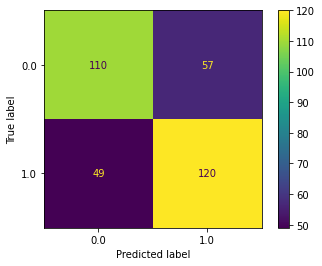

In [35]:
estimator.fit(X_train, y_train)
y_pred = estimator.predict(X_test)
eer = compute_eer(y_test, y_pred, positive_label = 1)
print("EER: ", eer)
cm = pcm(estimator, X_test, y_test)
print(cm)

In [36]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.69      0.66      0.67       167
         1.0       0.68      0.71      0.69       169

    accuracy                           0.68       336
   macro avg       0.68      0.68      0.68       336
weighted avg       0.68      0.68      0.68       336



## Naive GB

In [82]:
X = main[:,0:-1]
y = main[:,-1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [84]:
clf = GaussianNB()
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print('Accuracy : '+str(accuracy_score(y_test, y_pred)))

Accuracy : 0.6468253968253969


## GMM

In [86]:
X = main[:,0:-1]
y = main[:,-1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [88]:
clf = GaussianMixture()
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print('Accuracy of Gaussian Mixture: '+str(accuracy_score(y_test, y_pred)))

Accuracy of Gaussian Mixture: 0.5257936507936508


In [89]:
clf = BayesianGaussianMixture()
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print('Accuracy of Bayesian Gaussian Mixture: '+str(accuracy_score(y_test, y_pred)))

Accuracy of Bayesian Gaussian Mixture: 0.5257936507936508


## Encoder

https://www.geeksforgeeks.org/ml-classifying-data-using-an-auto-encoder/?ref=lbp

In [37]:
X = main[:,0:-1]
y = main[:,-1]

In [38]:
# Cleaning data to make it suitable for auto-encoder

X_scaled = MinMaxScaler().fit_transform(X)
X_normal_scaled = X_scaled[y == 0]
X_fraud_scaled = X_scaled[y == 1]

In [39]:
# Building auto-encoder for neural network

# Building the Input Layer
input_layer = Input(shape =(X.shape[1], ))
  
# Building the Encoder network
encoded = Dense(100, activation ='tanh',
                activity_regularizer = regularizers.l1(10e-5))(input_layer)
encoded = Dense(50, activation ='tanh',
                activity_regularizer = regularizers.l1(10e-5))(encoded)
encoded = Dense(25, activation ='tanh',
                activity_regularizer = regularizers.l1(10e-5))(encoded)
encoded = Dense(12, activation ='tanh',
                activity_regularizer = regularizers.l1(10e-5))(encoded)
encoded = Dense(6, activation ='relu')(encoded)
  
# Building the Decoder network
decoded = Dense(12, activation ='tanh')(encoded)
decoded = Dense(25, activation ='tanh')(decoded)
decoded = Dense(50, activation ='tanh')(decoded)
decoded = Dense(100, activation ='tanh')(decoded)
  
# Building the Output Layer
output_layer = Dense(X.shape[1], activation ='relu')(decoded)

In [40]:
# Defining and training the autoencoder

# Defining the parameters of the Auto-encoder network
autoencoder = Model(input_layer, output_layer)
autoencoder.compile(optimizer ="adadelta", loss ="binary_crossentropy")
  
# Training the Auto-encoder network
autoencoder.fit(X[y==0], X[y==0], 
                batch_size = 16, epochs = 10, 
                shuffle = True, validation_split = 0.20)

Epoch 1/10
42/42 [==============================] - 2s 9ms/step - loss: 0.0099 - val_loss: -0.0061
Epoch 2/10
42/42 [==============================] - 0s 3ms/step - loss: 0.0052 - val_loss: -0.0085
Epoch 3/10
42/42 [==============================] - 0s 3ms/step - loss: 0.0039 - val_loss: -0.0101
Epoch 4/10
42/42 [==============================] - 0s 3ms/step - loss: 0.0025 - val_loss: -0.0114
Epoch 5/10
42/42 [==============================] - 0s 3ms/step - loss: 9.9868e-04 - val_loss: -0.0127
Epoch 6/10
42/42 [==============================] - 0s 3ms/step - loss: 6.2927e-05 - val_loss: -0.0133
Epoch 7/10
42/42 [==============================] - 0s 3ms/step - loss: -6.2520e-04 - val_loss: -0.0138
Epoch 8/10
42/42 [==============================] - 0s 3ms/step - loss: -9.4689e-04 - val_loss: -0.0141
Epoch 9/10
42/42 [==============================] - 0s 3ms/step - loss: -0.0013 - val_loss: -0.0148
Epoch 10/10
42/42 [==============================] - 0s 3ms/step - loss: -0.0018 - val_los

In [41]:
# Retaining the encoder part of the Auto-encoder to encode data

hidden_representation = Sequential()
hidden_representation.add(autoencoder.layers[0])
hidden_representation.add(autoencoder.layers[1])
hidden_representation.add(autoencoder.layers[2])
hidden_representation.add(autoencoder.layers[3])
hidden_representation.add(autoencoder.layers[4])

In [42]:
# Encoding the data and visualizing the encoded data

# Separating the points encoded by the Auto-encoder as normal and fraud
normal_hidden_rep = hidden_representation.predict(X_normal_scaled)
fraud_hidden_rep = hidden_representation.predict(X_fraud_scaled)
  
# Combining the encoded points into a single table 
encoded_X = np.append(normal_hidden_rep, fraud_hidden_rep, axis = 0)
y_normal = np.zeros(normal_hidden_rep.shape[0])
y_fraud = np.ones(fraud_hidden_rep.shape[0])
encoded_y = np.append(y_normal, y_fraud)

In [43]:
#Splitting the original and encoded data into training and testing data

# Splitting the encoded data for linear classification
X_train_encoded, X_test_encoded, y_train_encoded, y_test_encoded = train_test_split(encoded_X, encoded_y, test_size = 0.2)
  
# Splitting the original data for non-linear classification
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [44]:
# Building the Logistic Regression model and evaluating it’s performance

# Building the logistic regression model
lrclf = LogisticRegression()
lrclf.fit(X_train_encoded, y_train_encoded)
  
# Storing the predictions of the linear model
y_pred_lrclf = lrclf.predict(X_test_encoded)
  
# Evaluating the performance of the linear model
print('Accuracy : '+str(accuracy_score(y_test_encoded, y_pred_lrclf)))

Accuracy : 0.6517857142857143


In [45]:
estimator = LogisticRegression()
kfold = StratifiedKFold(n_splits=5, shuffle=True)
results = cross_val_score(estimator, encoded_X, encoded_y, cv=kfold)
print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Baseline: 65.83% (2.97%)


In [46]:
# Building the Support Vector Machine and evaluating it’s performance

# Building the SVM model
svmclf = SVC()
svmclf.fit(X_train_encoded, y_train_encoded)
  
# Storing the predictions of the non-linear model
y_pred_svmclf = svmclf.predict(X_test_encoded)
  
# Evaluating the performance of the non-linear model
print('Accuracy : '+str(accuracy_score(y_test_encoded, y_pred_svmclf)))

Accuracy : 0.6696428571428571


In [47]:
estimator = RandomForestClassifier()
estimator.fit(X_train_encoded, y_train_encoded)
  
# Storing the predictions of the non-linear model
y_pred = estimator.predict(X_test_encoded)
  
# Evaluating the performance of the non-linear model
print('Accuracy : '+str(accuracy_score(y_test_encoded, y_pred)))

Accuracy : 0.7261904761904762


In [48]:
estimator = SVC()
kfold = StratifiedKFold(n_splits=5, shuffle=True)
results = cross_val_score(estimator, encoded_X, encoded_y, cv=kfold)
print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Baseline: 69.88% (1.86%)


In [49]:
estimator = RandomForestClassifier()
kfold = StratifiedKFold(n_splits=5, shuffle=True)
results = cross_val_score(estimator, encoded_X, encoded_y, cv=kfold)
print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Baseline: 75.48% (1.51%)


In [50]:
print(encoded_X.shape, encoded_y.shape)

(1680, 12) (1680,)


In [51]:
# baseline model
def create_baseline():
	# create model
  model = Sequential()
  model.add(Dense(12, input_dim=12, activation='relu'))
  model.add(Dense(6, activation='relu'))
  model.add(Dense(1, activation='sigmoid'))
	# Compile model
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model

estimator = KerasClassifier(build_fn=create_baseline, epochs=100, batch_size=5, verbose=0)
kfold = StratifiedKFold(n_splits=5, shuffle=True)
results = cross_val_score(estimator, encoded_X, encoded_y, cv=kfold)
print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  if sys.path[0] == '':


Baseline: 71.37% (2.21%)
